<a href="https://colab.research.google.com/github/knoel99/MNIST/blob/master/MNIST_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Réseau de neurones MNIST from scratch

Dans ce notebook, vous allez voir comment entraîner votre premier réseau de neurones (RN) pour reconnaître des chiffres sur une image.

Nous allons progressivement construire notre compréhension :
1. **Section 1** : Implémentation simple avec fonction identité
2. **Section 2** : Introduction des fonctions d'activation (Sigmoid, ReLU)
3. **Section 3** : Optimisation GPU (optionnelle)

---

## Section 1 : Implémentation simple avec fonction identité

**Objectif** : Comprendre les bases avec le code le plus simple possible

Pour faire simple, le RN ne fera qu'une couche, utilisera la fonction identité comme activation, et nous n'utiliserons pas de librairie comme pytorch pour faire l'entraînement.

### 1.1 Téléchargement et préparation des données

In [1]:
# Download the train and test data
!wget "https://github.com/knoel99/MNIST/raw/master/mnist_train.csv.zip"
!wget "https://github.com/knoel99/MNIST/raw/master/mnist_test.csv.zip"

--2025-08-28 16:42:14--  https://github.com/knoel99/MNIST/raw/master/mnist_train.csv.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/knoel99/MNIST/master/mnist_train.csv.zip [following]
--2025-08-28 16:42:14--  https://raw.githubusercontent.com/knoel99/MNIST/master/mnist_train.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13692401 (13M) [application/zip]
Saving to: ‘mnist_train.csv.zip.1’

mnist_train.csv.zip 100%[===================>]  13.06M  11.1MB/s    in 1.2s    

2025-08-28 16:42:16 (11.1 MB/s) - ‘mnist_train.csv.zip.1’ saved [13692401/13692401]

--2025-08-28 16:42:17--  http

In [2]:
# unzip
!ls -lh
!unzip  mnist_train.csv.zip
!unzip  mnist_test.csv.zip

total 50M
-rw-r--r-- 1 kim kim 1.2M Aug 28 16:41 MNIST_from_scratch.ipynb
-rw-r--r-- 1 kim kim    7 Aug 28 16:29 README.md
-rw-r--r-- 1 kim kim  18M Aug 28 16:29 mnist_test.csv
-rw-r--r-- 1 kim kim 2.2M Aug 28 16:29 mnist_test.csv.zip
-rw-r--r-- 1 kim kim 2.2M Aug 28 16:42 mnist_test.csv.zip.1
-rw-r--r-- 1 kim kim  14M Aug 28 16:29 mnist_train.csv.zip
-rw-r--r-- 1 kim kim  14M Aug 28 16:42 mnist_train.csv.zip.1
-rw-r--r-- 1 kim kim  208 Aug 28 16:29 nn_identity_biases.npy
-rw-r--r-- 1 kim kim  62K Aug 28 16:29 nn_identity_weights.npy
-rw-r--r-- 1 kim kim  208 Aug 28 16:29 nn_relu_biases.npy
-rw-r--r-- 1 kim kim  62K Aug 28 16:29 nn_relu_weights.npy
-rw-r--r-- 1 kim kim  208 Aug 28 16:29 nn_sigmoid_biases.npy
-rw-r--r-- 1 kim kim  62K Aug 28 16:29 nn_sigmoid_weights.npy
Archive:  mnist_train.csv.zip
  inflating: mnist_train.csv         
Archive:  mnist_test.csv.zip
replace mnist_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
# Let's visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the dataset
# Assuming you've already uploaded the CSV files to your Colab environment
mnist_train_path = 'mnist_train.csv' # Update this path if necessary
mnist_test_path = 'mnist_test.csv'   # Update this path if necessary

train_data = pd.read_csv(mnist_train_path)
test_data = pd.read_csv(mnist_test_path)

# Step 2: Display some of the images and labels
def display_image(data, index):
    """Display an image and its label."""
    # The first column is the label
    label = data.iloc[index, 0]
    # The rest of the columns are pixels
    pixels = data.iloc[index, 1:].values.reshape((28, 28))
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

# Display the first 5 images in the training set
for i in range(5):
    display_image(train_data, i)


ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Load the dataset in dataframe

import pandas as pd
import numpy as np

# Load the dataset
mnist_train_path = 'mnist_train.csv' # Update this path if necessary
train_data = pd.read_csv(mnist_train_path)

# Assuming the first column 'label' is the target variable and the rest are features
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values

# Normalize the features to be between 0 and 1
X_train = X_train / 255.0

# Convert y_train to one-hot encoding
def one_hot_encode(y, num_classes):
    """Convert a vector of labels to one-hot encoded format."""
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

y_train = one_hot_encode(y_train, 10) # 10 classes for digits 0-9


In [ ]:
import numpy as np

def mean_squared_error(y_true, y_pred):
    """
    Calculate the mean squared error between true labels and predictions.
    """
    mse = np.mean(np.square(y_true - y_pred))
    return mse

### 1.2 Implémentation simple du réseau de neurones

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

class SimpleIdentityNetwork:
    def __init__(self, input_size, output_size):
        """
        Réseau de neurones simple avec fonction identité.
        
        Parameters:
        - input_size: nombre de features en entrée (784 pour MNIST)
        - output_size: nombre de classes (10 pour les chiffres 0-9)
        """
        # Initialisation des poids et biais
        self.weights = 0.01 * np.random.randn(input_size, output_size)
        self.bias = np.zeros((1, output_size))
        
        # Historique pour le suivi de l'entraînement
        self.loss_history = []
        
    def predict(self, X):
        """
        Prédiction avec fonction identité (pas d'activation).
        """
        z = np.dot(X, self.weights) + self.bias
        return z  # Fonction identité : f(z) = z
    
    def train(self, X, y, epochs, learning_rate):
        """
        Entraînement du réseau avec descente de gradient.
        """
        for epoch in range(epochs):
            # Forward pass
            predictions = self.predict(X)
            
            # Calcul de la loss (Mean Squared Error)
            loss = np.mean((predictions - y) ** 2)
            self.loss_history.append(loss)
            
            # Backpropagation
            # Dérivée de la loss par rapport aux prédictions
            d_loss = 2 * (predictions - y) / y.size
            
            # Gradients (fonction identité : dérivée = 1)
            d_weights = np.dot(X.T, d_loss)
            d_bias = np.sum(d_loss, axis=0, keepdims=True)
            
            # Mise à jour des paramètres
            self.weights -= learning_rate * d_weights
            self.bias -= learning_rate * d_bias
            
            # Affichage du progrès
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
    def plot_loss(self):
        """
        Visualisation simple de l'évolution de la loss.
        """
        plt.figure(figsize=(8, 5))
        plt.plot(self.loss_history)
        plt.title('Évolution de la Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error')
        plt.grid(True)
        plt.show()

In [ ]:
def visualize_simple_network():
    """
    Visualise l'architecture simple du réseau de neurones avec fonction identité.
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Positions
    input_x = 2
    output_x = 10
    
    # Dessiner la couche d'entrée
    ax.add_patch(patches.Rectangle((input_x-0.5, 2), 1, 3, 
                                   fill=True, facecolor='lightblue', 
                                   edgecolor='black', linewidth=2))
    ax.text(input_x, 6, 'Couche d\'Entrée', ha='center', fontsize=12, weight='bold')
    ax.text(input_x, 1.5, '784 pixels\n(28×28 image)', ha='center', fontsize=10)
    
    # Dessiner la couche de sortie
    ax.add_patch(patches.Rectangle((output_x-0.5, 2.5), 1, 2, 
                                   fill=True, facecolor='lightgreen', 
                                   edgecolor='black', linewidth=2))
    ax.text(output_x, 6, 'Couche de Sortie', ha='center', fontsize=12, weight='bold')
    ax.text(output_x, 1.5, '10 classes\n(chiffres 0-9)', ha='center', fontsize=10)
    
    # Dessiner quelques connexions représentatives
    for i in range(4):
        y_start = 2.2 + i * 0.6
        y_end = 2.7 + i * 0.3
        ax.arrow(input_x+0.5, y_start, 7, y_end-y_start, 
                head_width=0.1, head_length=0.2, 
                fc='gray', ec='gray', alpha=0.6, linewidth=1)
    
    # Ajouter des points pour représenter plus de connexions
    ax.text(6, 4, '...', ha='center', va='center', fontsize=20, alpha=0.7)
    ax.text(6, 3, 'Toutes les connexions\n(784 × 10 = 7840 poids)', 
           ha='center', fontsize=10, style='italic')
    
    # Fonction d'activation
    ax.text(6, 5.5, 'Fonction Identité: f(x) = x', 
           ha='center', fontsize=12, weight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
    
    # Équation du réseau
    ax.text(6, 0.5, 'Sortie = Entrée × Poids + Biais', 
           ha='center', fontsize=11, weight='bold',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    
    # Mise en forme
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 7)
    ax.axis('off')
    ax.set_title('Architecture du Réseau de Neurones Simple (Section 1)', 
                fontsize=14, weight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

# Affichage de l'architecture
print("=== Architecture du réseau de neurones ===")
visualize_simple_network()

### 1.3 Entraînement du modèle simple

In [ ]:
# Création et entraînement du modèle simple avec fonction identité
simple_nn = SimpleIdentityNetwork(input_size=784, output_size=10)
simple_nn.train(X_train, y_train, epochs=1000, learning_rate=0.01)

In [ ]:
# Visualisation de l'évolution de la loss
simple_nn.plot_loss()

### 1.4 Évaluation simple du modèle

In [ ]:
def visualize_network_architecture(activation='identity'):
    """
    Visualise l'architecture du réseau avec différentes fonctions d'activation.
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    # Couleurs pour les différentes activations
    activation_colors = {
        'identity': 'yellow',
        'sigmoid': 'orange', 
        'relu': 'lightcoral'
    }
    
    # Positions
    input_x = 2
    output_x = 10
    
    # Dessiner la couche d'entrée
    ax.add_patch(patches.Rectangle((input_x-0.5, 2), 1, 3, 
                                   fill=True, facecolor='lightblue', 
                                   edgecolor='black', linewidth=2))
    ax.text(input_x, 6, 'Couche d\'Entrée', ha='center', fontsize=12, weight='bold')
    ax.text(input_x, 1.5, '784 neurons\n(28×28 pixels)', ha='center', fontsize=10)
    
    # Dessiner la couche de sortie
    ax.add_patch(patches.Rectangle((output_x-0.5, 2.5), 1, 2, 
                                   fill=True, facecolor='lightgreen', 
                                   edgecolor='black', linewidth=2))
    ax.text(output_x, 6, 'Couche de Sortie', ha='center', fontsize=12, weight='bold')
    ax.text(output_x, 1.5, '10 neurons\n(classes 0-9)', ha='center', fontsize=10)
    
    # Dessiner les connexions avec weights
    for i in range(5):
        y_start = 2.1 + i * 0.6
        y_end = 2.6 + i * 0.2
        # Épaisseur variable pour suggérer différents poids
        linewidth = 1 + (i % 3)
        ax.arrow(input_x+0.5, y_start, 7, y_end-y_start, 
                head_width=0.08, head_length=0.15, 
                fc='gray', ec='gray', alpha=0.7, linewidth=linewidth)
    
    # Texte pour les connexions
    ax.text(6, 4, 'Poids (W)', ha='center', va='center', fontsize=11, weight='bold')
    ax.text(6, 3.5, '784 × 10 = 7,840 paramètres', ha='center', fontsize=9, style='italic')
    
    # Fonction d'activation avec formule
    color = activation_colors.get(activation, 'yellow')
    
    if activation == 'identity':
        formula = 'f(x) = x'
        description = 'Sortie = Entrée'
    elif activation == 'sigmoid':
        formula = 'f(x) = 1/(1+e⁻ˣ)'
        description = 'Sortie ∈ [0, 1]'
    elif activation == 'relu':
        formula = 'f(x) = max(0, x)'
        description = 'Sortie = max(0, Entrée)'
    
    ax.text(6, 5.8, f'Fonction {activation.capitalize()}', 
           ha='center', fontsize=12, weight='bold')
    ax.text(6, 5.3, formula, ha='center', fontsize=11, 
           bbox=dict(boxstyle='round,pad=0.4', facecolor=color, alpha=0.8))
    ax.text(6, 4.8, description, ha='center', fontsize=9, style='italic')
    
    # Équation complète
    ax.text(6, 0.8, 'y = f(x·W + b)', ha='center', fontsize=12, weight='bold',
           bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgray', alpha=0.8))
    ax.text(6, 0.3, 'x: entrée, W: poids, b: biais, f: activation', 
           ha='center', fontsize=9, style='italic')
    
    # Mise en forme
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 7)
    ax.axis('off')
    ax.set_title(f'Architecture avec Fonction {activation.capitalize()}', 
                fontsize=14, weight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

def visualize_learned_weights(network, title="Poids appris", activation=""):
    """
    Visualise les poids appris comme des 'filtres' pour chaque chiffre.
    """
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.ravel()
    
    for digit in range(10):
        # Reshape les poids pour ce chiffre en image 28x28
        weights = network.weights[:, digit].reshape(28, 28)
        
        # Normalisation pour la visualisation
        weights_norm = (weights - weights.min()) / (weights.max() - weights.min())
        
        # Affichage avec une colormap qui montre les poids positifs/négatifs
        im = axes[digit].imshow(weights, cmap='RdBu_r', aspect='auto')
        axes[digit].set_title(f'Poids pour chiffre {digit}', fontsize=11, weight='bold')
        axes[digit].axis('off')
        
        # Colorbar compacte
        cbar = plt.colorbar(im, ax=axes[digit], fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
    
    plt.suptitle(f'{title} - {activation}', fontsize=14, weight='bold')
    plt.figtext(0.5, 0.02, 
                'Rouge = poids négatifs, Bleu = poids positifs\n'
                'Les patterns montrent ce que chaque neurone "recherche" dans l\'image', 
                ha='center', fontsize=10, style='italic')
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

def compare_activation_functions():
    """
    Compare visuellement les différentes fonctions d'activation.
    """
    import numpy as np
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    x = np.linspace(-5, 5, 100)
    
    # Identity
    y_identity = x
    axes[0].plot(x, y_identity, 'b-', linewidth=3)
    axes[0].set_title('Fonction Identité\nf(x) = x', fontsize=12, weight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(0, color='k', linewidth=0.5)
    axes[0].axvline(0, color='k', linewidth=0.5)
    
    # Sigmoid
    y_sigmoid = 1 / (1 + np.exp(-x))
    axes[1].plot(x, y_sigmoid, 'orange', linewidth=3)
    axes[1].set_title('Fonction Sigmoid\nf(x) = 1/(1+e⁻ˣ)', fontsize=12, weight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(0, color='k', linewidth=0.5)
    axes[1].axvline(0, color='k', linewidth=0.5)
    axes[1].set_ylim(-0.1, 1.1)
    
    # ReLU
    y_relu = np.maximum(0, x)
    axes[2].plot(x, y_relu, 'red', linewidth=3)
    axes[2].set_title('Fonction ReLU\nf(x) = max(0, x)', fontsize=12, weight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(0, color='k', linewidth=0.5)
    axes[2].axvline(0, color='k', linewidth=0.5)
    
    for ax in axes:
        ax.set_xlabel('Entrée (x)', fontsize=10)
        ax.set_ylabel('Sortie f(x)', fontsize=10)
    
    plt.suptitle('Comparaison des Fonctions d\'Activation', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

print("=== Fonctions de visualisation avancées définies ===")
print("- visualize_network_architecture(activation)")
print("- visualize_learned_weights(network, title, activation)")
print("- compare_activation_functions()")

In [ ]:
# Comparaison visuelle des fonctions d'activation
compare_activation_functions()

---

## Section 2 : Introduction des fonctions d'activation

**Objectif** : Comprendre l'impact des fonctions d'activation (Sigmoid, ReLU)

Maintenant que nous avons compris le fonctionnement de base avec la fonction identité, nous allons refactoriser notre code pour supporter différentes fonctions d'activation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def identity(x):
    return x

def identity_derivative(x):
    return np.ones_like(x)

class NeuralNetworkWithActivation:
    def __init__(self, input_size, output_size, activation='identity'):
        """
        Réseau de neurones avec choix de fonction d'activation.
        
        Parameters:
        - input_size: nombre de features en entrée (784 pour MNIST)
        - output_size: nombre de classes (10 pour les chiffres 0-9)
        - activation: 'identity', 'sigmoid', ou 'relu'
        """
        self.weights = 0.01 * np.random.randn(input_size, output_size)
        self.bias = np.zeros((1, output_size))
        
        # Historique pour le suivi de l'entraînement
        self.loss_history = []
        self.epoch_times = []
        
        # Définition des fonctions d'activation
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative
        elif activation == 'relu':
            self.activation = relu
            self.activation_derivative = relu_derivative
        else:  # Default to identity
            self.activation = identity
            self.activation_derivative = identity_derivative

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.activation(z)

    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            epoch_start_time = time.time()

            # Forward pass
            z = np.dot(X, self.weights) + self.bias
            predictions = self.activation(z)

            # Calcul de la loss
            loss = np.mean((predictions - y) ** 2)
            self.loss_history.append(loss)

            # Backpropagation
            d_loss = 2 * (predictions - y) / y.size
            d_activation = self.activation_derivative(z)
            d_z = d_loss * d_activation
            d_weights = np.dot(X.T, d_z)
            d_bias = np.sum(d_z, axis=0, keepdims=True)

            # Mise à jour des paramètres
            self.weights -= learning_rate * d_weights
            self.bias -= learning_rate * d_bias

            epoch_end_time = time.time()
            self.epoch_times.append(epoch_end_time - epoch_start_time)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}, Time: {(epoch_end_time - epoch_start_time):.4f} seconds")

In [ ]:
# Entraînement des trois modèles
print("=== Entraînement du modèle avec fonction identité ===")
nn_identity = NeuralNetworkWithActivation(input_size=784, output_size=10, activation='identity')
nn_identity.train(X_train, y_train, epochs=1000, learning_rate=0.01)

### 2.2 Entraînement comparatif des trois modèles

In [ ]:
# Visualisation des architectures avec différentes fonctions d'activation
print("=== Architecture des réseaux ===")
visualize_network_architecture('identity')
visualize_network_architecture('sigmoid') 
visualize_network_architecture('relu')

In [ ]:
# Visualisation des poids appris par chaque modèle
print("=== Poids appris par les différents modèles ===")
print("Ces visualisations montrent les 'filtres' que chaque modèle a appris à reconnaître pour chaque chiffre.")

visualize_learned_weights(nn_identity, "Modèle Identity", "Fonction Identité")
visualize_learned_weights(nn_sigmoid, "Modèle Sigmoid", "Fonction Sigmoid") 
visualize_learned_weights(nn_relu, "Modèle ReLU", "Fonction ReLU")

In [ ]:
print("=== Entraînement du modèle avec fonction ReLU ===")
nn_relu = NeuralNetworkWithActivation(input_size=784, output_size=10, activation='relu')
nn_relu.train(X_train, y_train, epochs=1000, learning_rate=0.01)

### 2.3 Comparaison des résultats

### 2.5 Évaluation comparative des performances

In [ ]:
# Fonction d'évaluation d'accuracy adaptée
def compute_accuracy_activation(network, X, y):
    """Calcule l'accuracy du réseau sur un jeu de données."""
    correct_predictions = 0
    for i in range(len(X)):
        prediction = network.predict(X[i:i+1])
        predicted_class = np.argmax(prediction)
        true_class = np.argmax(y[i])
        if predicted_class == true_class:
            correct_predictions += 1
    return (correct_predictions / len(X)) * 100

# Calcul des accuracies pour les trois modèles
print("=== Résultats finaux ===")
print(f"Identity - Train: {compute_accuracy_activation(nn_identity, X_train, y_train):.2f}%, Test: {compute_accuracy_activation(nn_identity, X_test, y_test):.2f}%")
print(f"Sigmoid  - Train: {compute_accuracy_activation(nn_sigmoid, X_train, y_train):.2f}%, Test: {compute_accuracy_activation(nn_sigmoid, X_test, y_test):.2f}%")
print(f"ReLU     - Train: {compute_accuracy_activation(nn_relu, X_train, y_train):.2f}%, Test: {compute_accuracy_activation(nn_relu, X_test, y_test):.2f}%")

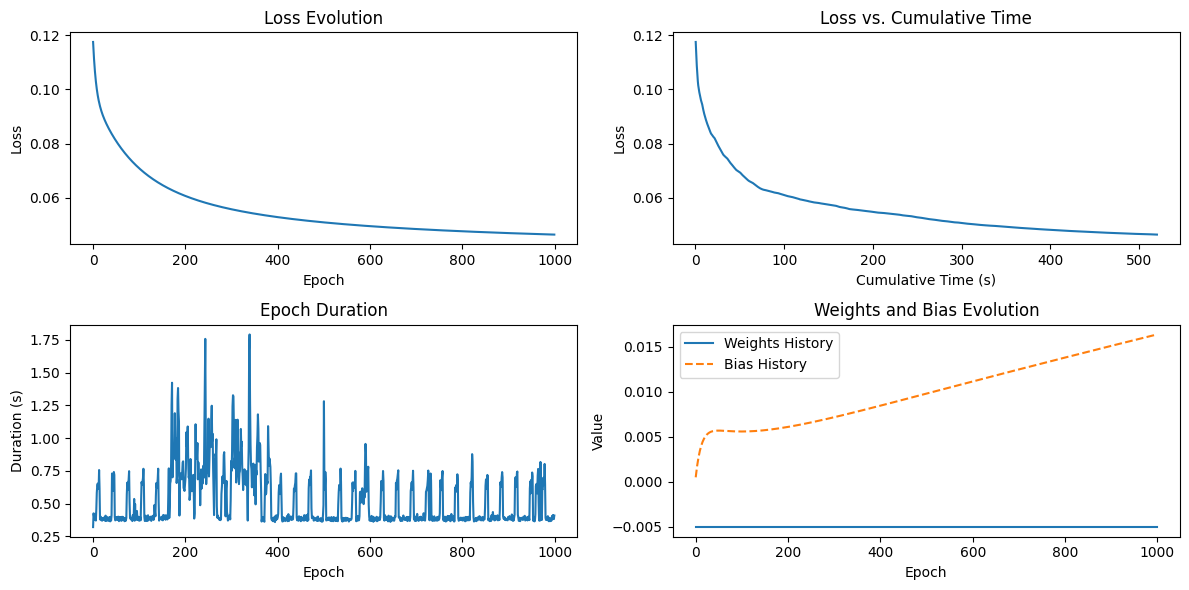

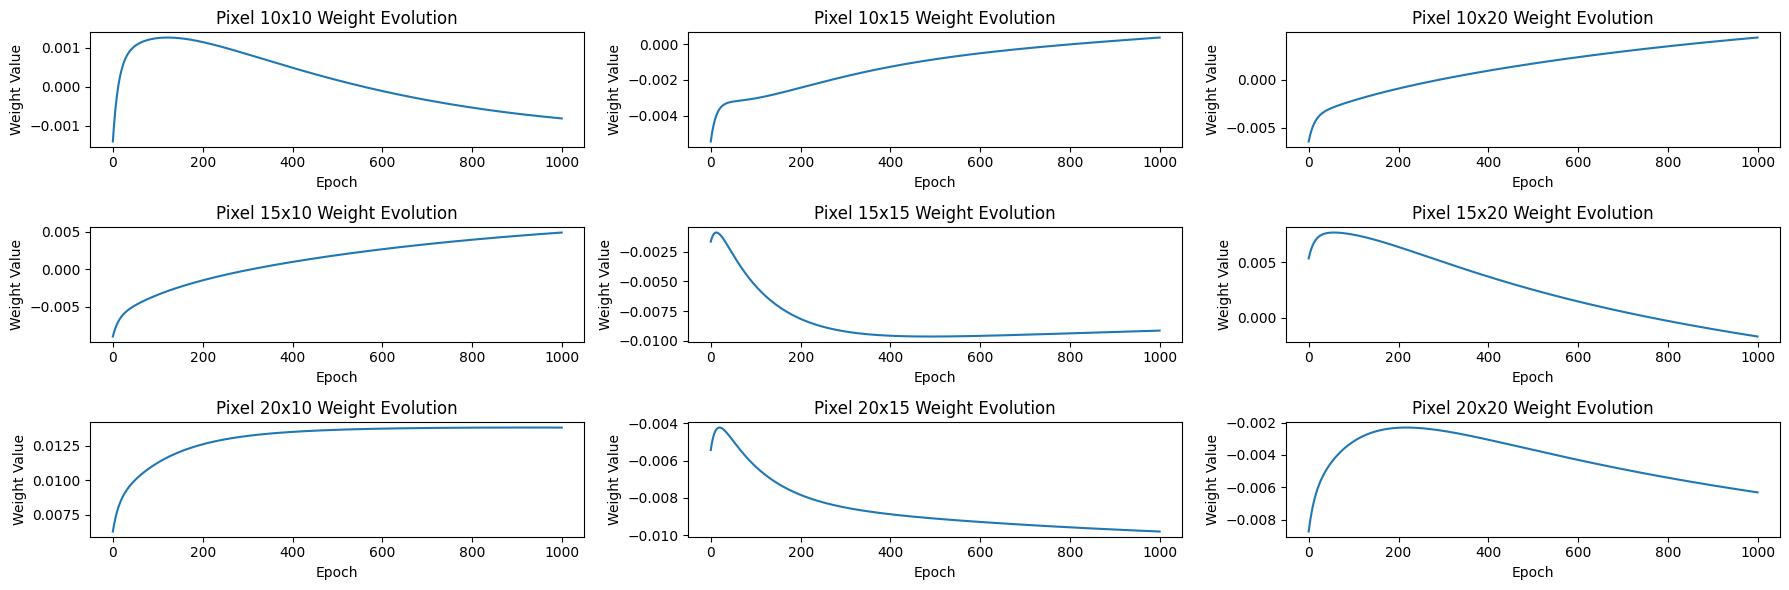

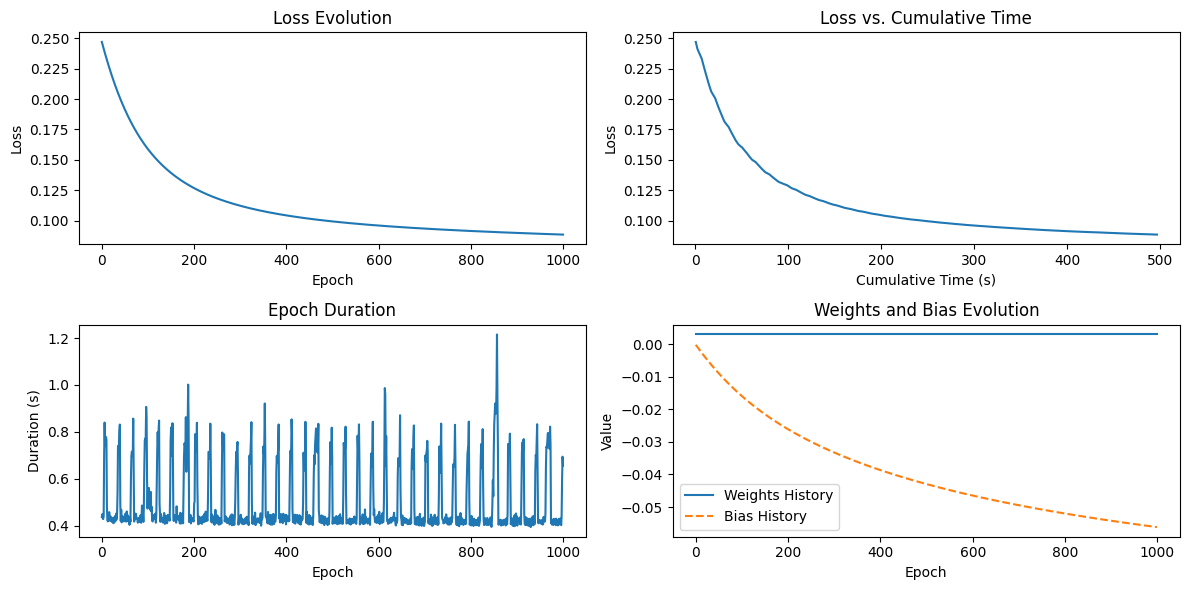

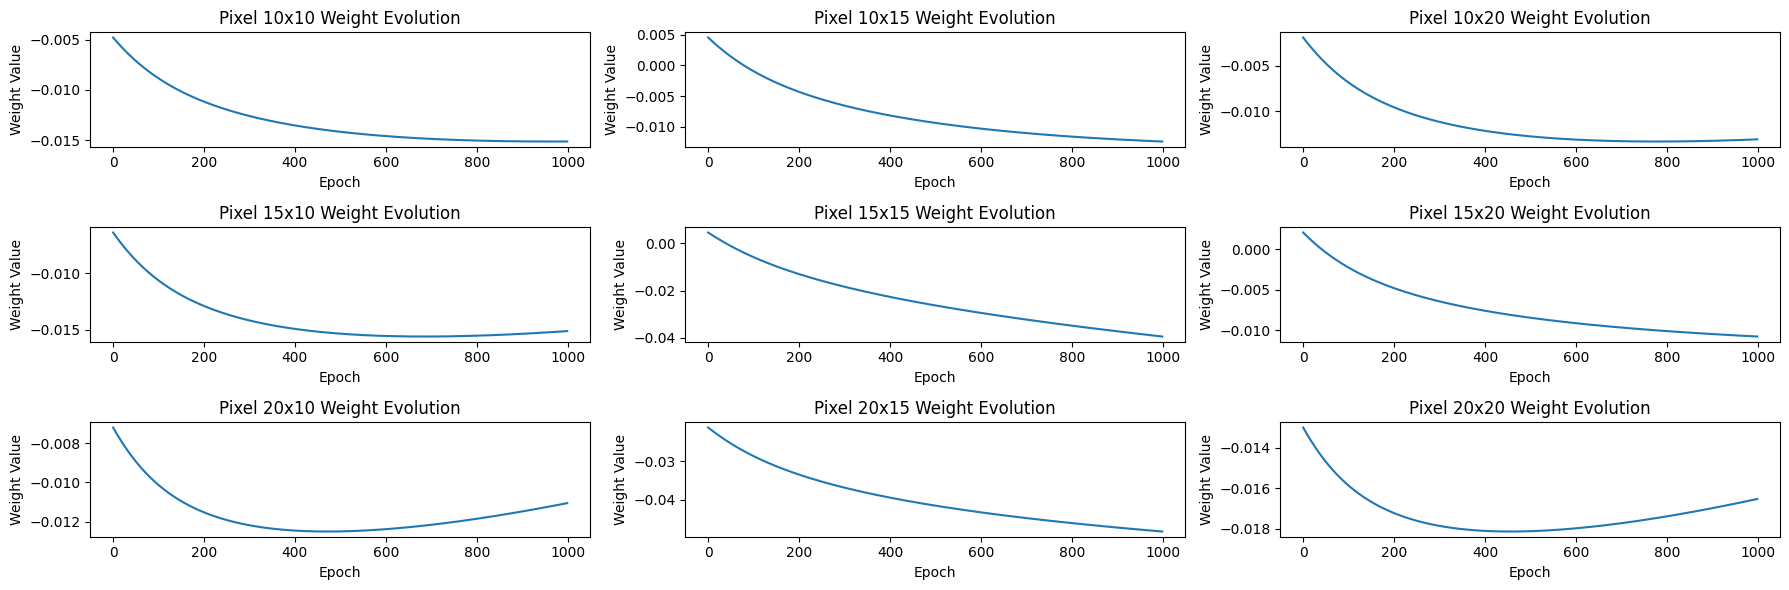

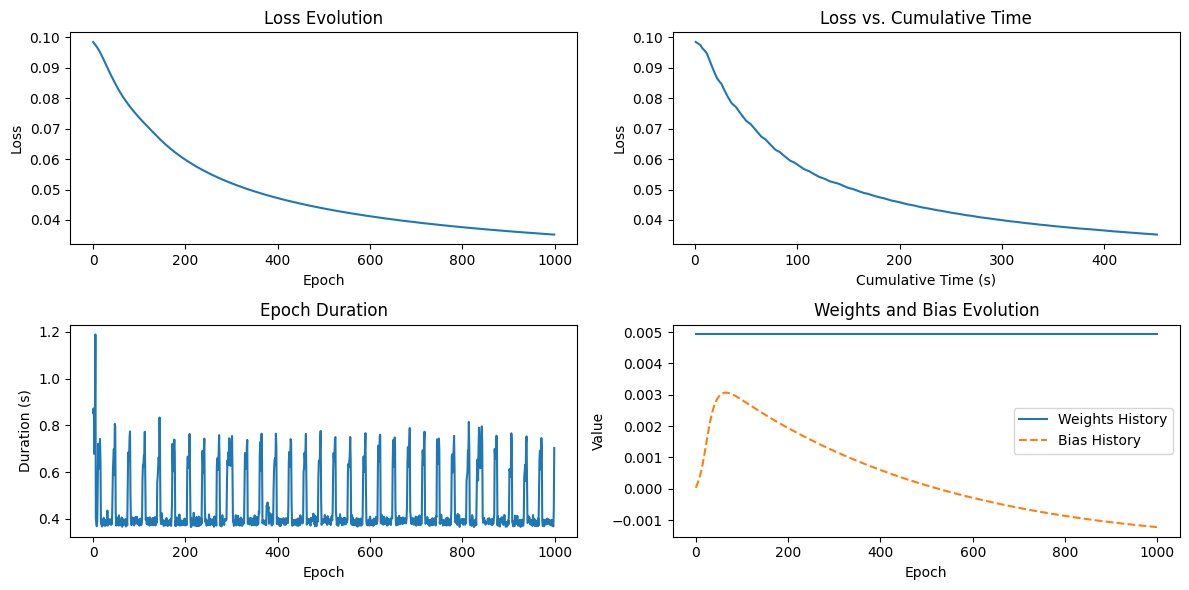

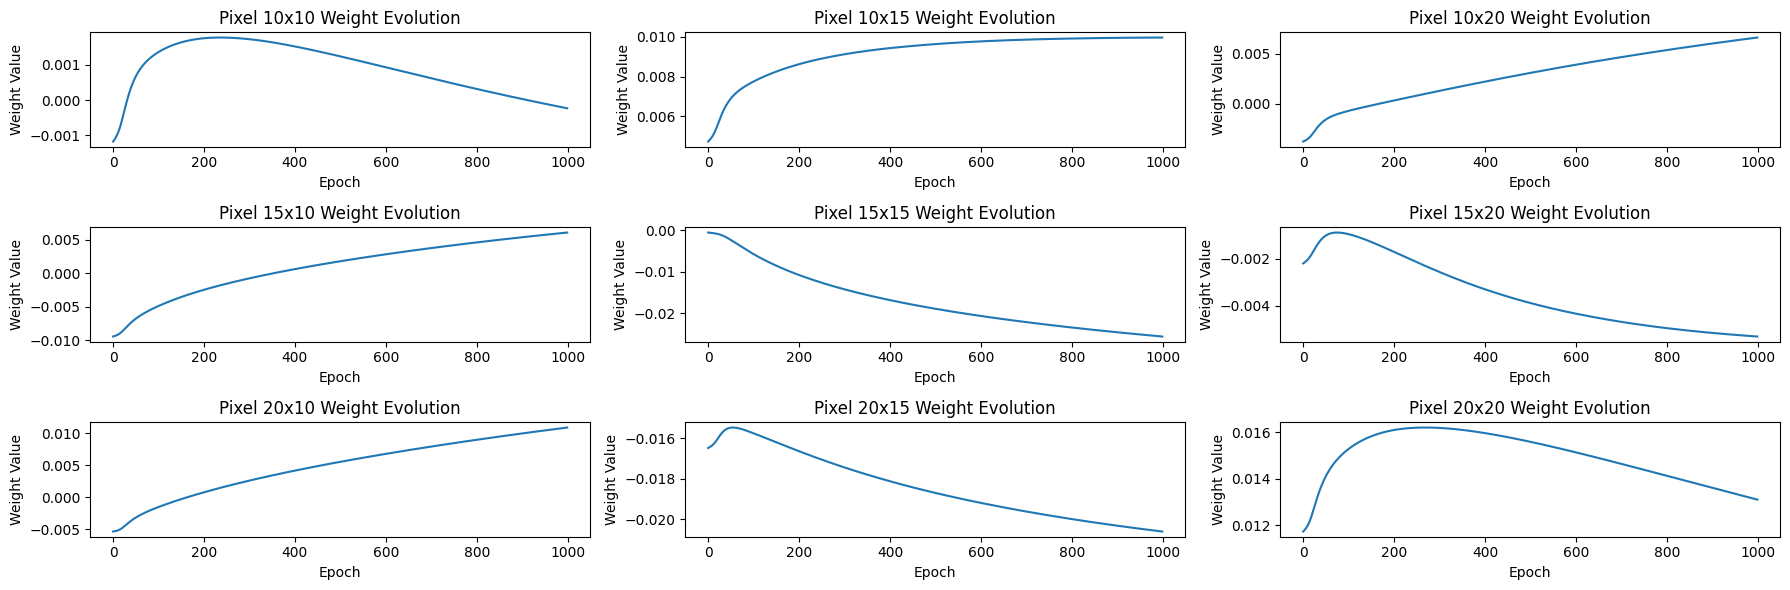

In [ ]:
nn_identity.plot_training_insights()
nn_sigmoid .plot_training_insights()
nn_relu    .plot_training_insights()

### 2.4 Évaluation comparative des performances

In [ ]:
def test_and_plot_accuracy_comparison(nn1, nn2, nn3, X_test, y_test, sota_accuracy=99.7):
    """
    Visualise l'évolution de l'accuracy au fur et à mesure du test pour les trois modèles.
    """
    correct_predictions1 = 0
    correct_predictions2 = 0  
    correct_predictions3 = 0

    test_accuracy_history1 = []
    test_accuracy_history2 = []
    test_accuracy_history3 = []

    for i in range(len(X_test)):
        true_class = np.argmax(y_test[i])

        prediction1 = nn1.predict(X_test[i:i+1])
        prediction2 = nn2.predict(X_test[i:i+1])
        prediction3 = nn3.predict(X_test[i:i+1])

        predicted_class1 = np.argmax(prediction1)
        predicted_class2 = np.argmax(prediction2)
        predicted_class3 = np.argmax(prediction3)

        if predicted_class1 == true_class:
            correct_predictions1 += 1
        if predicted_class2 == true_class:
            correct_predictions2 += 1
        if predicted_class3 == true_class:
            correct_predictions3 += 1

        # Accuracy courante
        current_accuracy1 = (correct_predictions1 / (i + 1)) * 100
        current_accuracy2 = (correct_predictions2 / (i + 1)) * 100
        current_accuracy3 = (correct_predictions3 / (i + 1)) * 100

        test_accuracy_history1.append(current_accuracy1)
        test_accuracy_history2.append(current_accuracy2)
        test_accuracy_history3.append(current_accuracy3)

    # Graphique de l'évolution de l'accuracy
    plt.figure(figsize=(12, 6))

    plt.plot(test_accuracy_history1, color='b', label='Identity')
    plt.plot(test_accuracy_history2, color='m', label='Sigmoid')
    plt.plot(test_accuracy_history3, color='g', label='ReLU')

    plt.axhline(y=sota_accuracy, color='r', linestyle='-', label=f'SOTA Accuracy ({sota_accuracy}%)')

    plt.title('Évolution de l\'Accuracy sur les données de test')
    plt.xlabel('Nombre d\'échantillons testés')
    plt.ylabel('Accuracy (%)')
    plt.ylim(50, 100)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

test_and_plot_accuracy_comparison(nn_identity, nn_sigmoid, nn_relu, X_test, y_test)

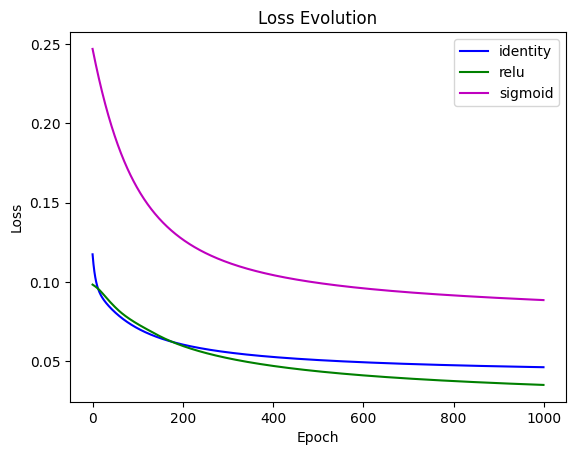

In [ ]:
def plot_compare_loss(nn1, nn2, nn3):
  plt.plot(nn1.loss_history, color='b',label='identity')
  plt.plot(nn3.loss_history, color='g',label='relu')
  plt.plot(nn2.loss_history, color='m',label='sigmoid')

  plt.title('Loss Evolution')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

plot_compare_loss(nn_identity, nn_sigmoid, nn_relu)


In [ ]:
print(len(nn_identity.loss_history))

1000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the test data (similar to how you prepared the training data)
mnist_test_path = 'mnist_test.csv' # Update this path if necessary
test_data = pd.read_csv(mnist_test_path)
X_test = test_data.drop('label', axis=1).values / 255.0
y_test = one_hot_encode(test_data['label'].values, 10)


def compute_accuracy(network, X, y):
    correct_predictions = 0
    for i in range(len(X)):
        prediction = network.predict(X[i:i+1])
        predicted_class = np.argmax(prediction)
        true_class = np.argmax(y[i])
        if predicted_class == true_class:
            correct_predictions += 1
    return (correct_predictions / len(X)) * 100


def test_and_plot_accuracy1(nn1, X_train, y_train, X_test, y_test, sota_accuracy=99.7):
    # Compute training set accuracy first
    training_accuracy1 = compute_accuracy(nn1, X_train, y_train)

    correct_predictions1 = 0

    test_accuracy_history1 = []

    for i in range(len(X_test)):
        true_class = np.argmax(y_test[i])

        prediction1 = nn1.predict(X_test[i:i+1])

        predicted_class1 = np.argmax(prediction1)

        if predicted_class1 == true_class:
            correct_predictions1 += 1

        # Current accuracy
        current_accuracy1 = (correct_predictions1 / (i + 1)) * 100

        test_accuracy_history1.append(current_accuracy1)

        # Cumulative average accuracy up to current sample
        cumulative_average_accuracy1 = np.mean(test_accuracy_history1)

    # Plot the accuracy evolution
    plt.figure(figsize=(10, 6))

    plt.plot(test_accuracy_history1, color='b', label='Identity')
    plt.axhline(y=training_accuracy1, color='b', linestyle='--', label=f'Average accuracy Identity ({training_accuracy1:.2f}%)')

    plt.axhline(y=sota_accuracy, color='r', linestyle='-', label=f'SOTA Accuracy ({sota_accuracy}%)')

    plt.title('Accuracy Evolution')
    plt.xlabel('Number of Samples Checked')
    plt.ylabel('Accuracy (%)')
    plt.ylim(50, 100)
    plt.legend(loc='lower right')
    plt.show()


def test_and_plot_accuracy(nn1, nn2, nn3, X_train, y_train, X_test, y_test, sota_accuracy=99.7):
    # Compute training set accuracy first
    training_accuracy1 = compute_accuracy(nn1, X_train, y_train)
    training_accuracy2 = compute_accuracy(nn2, X_train, y_train)
    training_accuracy3 = compute_accuracy(nn3, X_train, y_train)

    correct_predictions1 = 0
    correct_predictions2 = 0
    correct_predictions3 = 0

    test_accuracy_history1 = []
    test_accuracy_history2 = []
    test_accuracy_history3 = []

    for i in range(len(X_test)):
        true_class = np.argmax(y_test[i])

        prediction1 = nn1.predict(X_test[i:i+1])
        prediction2 = nn2.predict(X_test[i:i+1])
        prediction3 = nn3.predict(X_test[i:i+1])

        predicted_class1 = np.argmax(prediction1)
        predicted_class2 = np.argmax(prediction2)
        predicted_class3 = np.argmax(prediction3)

        if predicted_class1 == true_class:
            correct_predictions1 += 1
        if predicted_class2 == true_class:
            correct_predictions2 += 1
        if predicted_class3 == true_class:
            correct_predictions3 += 1

        # Current accuracy
        current_accuracy1 = (correct_predictions1 / (i + 1)) * 100
        current_accuracy2 = (correct_predictions2 / (i + 1)) * 100
        current_accuracy3 = (correct_predictions3 / (i + 1)) * 100

        test_accuracy_history1.append(current_accuracy1)
        test_accuracy_history2.append(current_accuracy2)
        test_accuracy_history3.append(current_accuracy3)

    # Plot the accuracy evolution
    plt.figure(figsize=(10, 6))

    plt.plot(test_accuracy_history1, color='b', label='Identity')
    plt.plot(test_accuracy_history2, color='g', label='Relu')
    plt.plot(test_accuracy_history3, color='m', label='Sigmoid')

    plt.axhline(y=training_accuracy1, color='b', linestyle='--', label=f'Average accuracy Identity ({training_accuracy1:.2f}%)')
    plt.axhline(y=training_accuracy2, color='g', linestyle='--', label=f'Average accuracy Relu ({training_accuracy2:.2f}%)')
    plt.axhline(y=training_accuracy3, color='m', linestyle='--', label=f'Average accuracy Sigmoid ({training_accuracy3:.2f}%)')

    plt.axhline(y=sota_accuracy, color='r', linestyle='-', label=f'SOTA Accuracy ({sota_accuracy}%)')

    plt.title('Accuracy Evolution')
    plt.xlabel('Number of Samples Checked')
    plt.ylabel('Accuracy (%)')
    plt.ylim(50, 100)
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
print("=== Exemples de classification pour Identity ===")
evaluate_and_plot_samples(nn_identity, X_test, y_test)

print("=== Exemples de classification pour Sigmoid ===")  
evaluate_and_plot_samples(nn_sigmoid, X_test, y_test)

print("=== Exemples de classification pour ReLU ===")
evaluate_and_plot_samples(nn_relu, X_test, y_test)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(X, y, indices, title, predictions=None, convert=True):
    """Plot a selection of images, their labels, and model predictions.

    Parameters:
    - X: The images.
    - y: The true labels.
    - indices: Indices of the images to plot.
    - title: Title for the plots.
    - predictions: The predicted labels for the provided indices.
    - convert: Boolean indicating if images need reshaping.
    """
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(indices[:5]):  # Plot up to 5 images from provided indices
        plt.subplot(1, 5, i + 1)
        img = X[idx].reshape(28, 28) if convert else X[idx]
        plt.imshow(img, cmap='gray')

        pred_text = f"Pred: {predictions[i]}" if predictions is not None else ""
        true_text = f"True: {np.argmax(y[idx])}"
        plt.title(f"{pred_text}\n{true_text}", fontsize=20, pad=5)
        plt.axis('off')

    plt.suptitle(title, fontsize=24, y=1.05)  # Adjust y parameter to lift the suptitle
    plt.tight_layout(pad=2.0)
    plt.show()


def evaluate_and_plot_samples(network, X_test, y_test):
    correct_indices = []
    incorrect_indices = []
    predictions = []

    for i in range(len(X_test)):
        prediction_vector = network.predict(X_test[i:i+1])
        predicted_class = np.argmax(prediction_vector)
        true_class = np.argmax(y_test[i])
        predictions.append(predicted_class)

        if predicted_class == true_class:
            #print("i = " + str(i) + " predicted_class=" + str(predicted_class) + " true_class= " + str(true_class))
            correct_indices.append(i)
        else:
            incorrect_indices.append(i)

        if len(correct_indices) >= 5 and len(incorrect_indices) >= 5:
            break

    # Extract predictions for correctly and incorrectly classified images
    correct_predictions = [predictions[i] for i in correct_indices]
    incorrect_predictions = [predictions[i] for i in incorrect_indices]

    # Plot correctly classified images with corresponding predictions
    plot_images(X_test, y_test, correct_indices, "Correctly Classified", [predictions[i] for i in correct_indices])

    # Plot incorrectly classified images with corresponding predictions
    plot_images(X_test, y_test, incorrect_indices, "Incorrectly Classified", [predictions[i] for i in incorrect_indices])


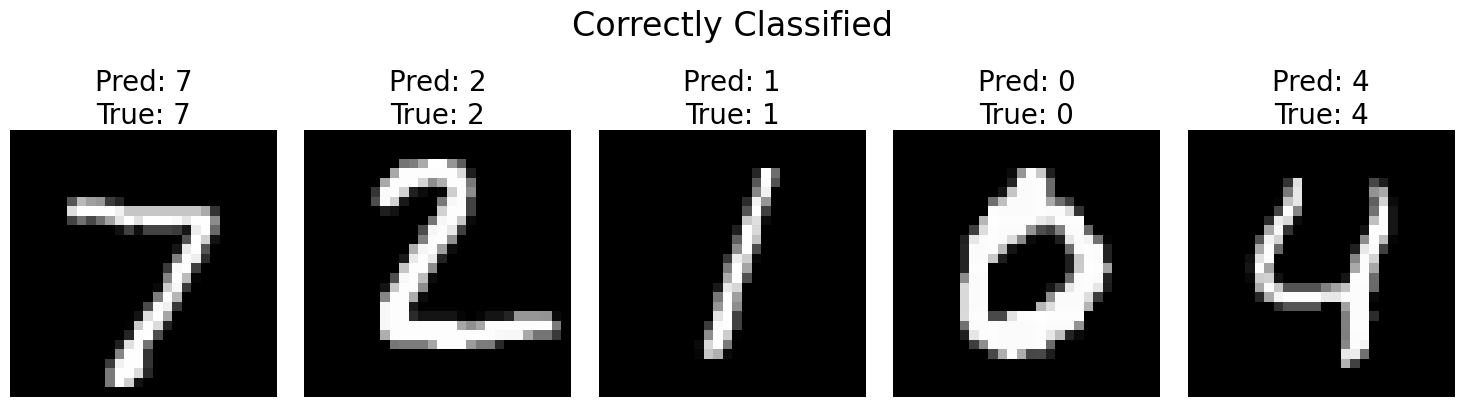

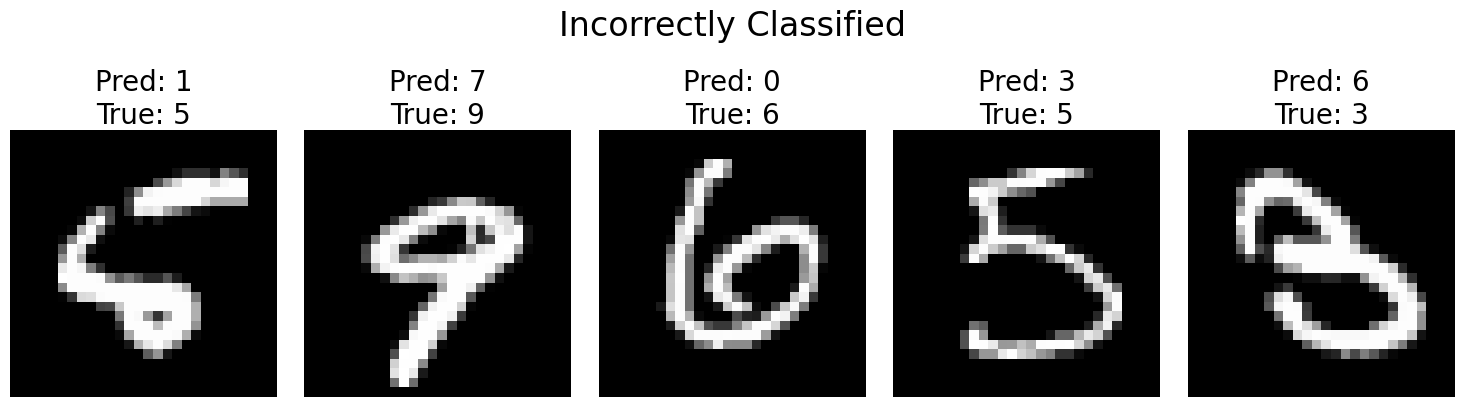

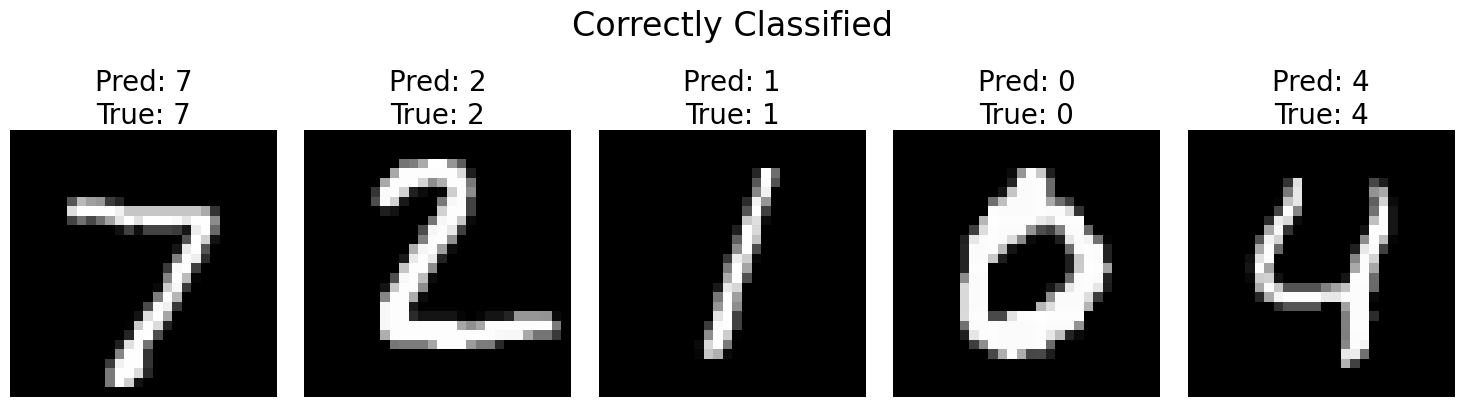

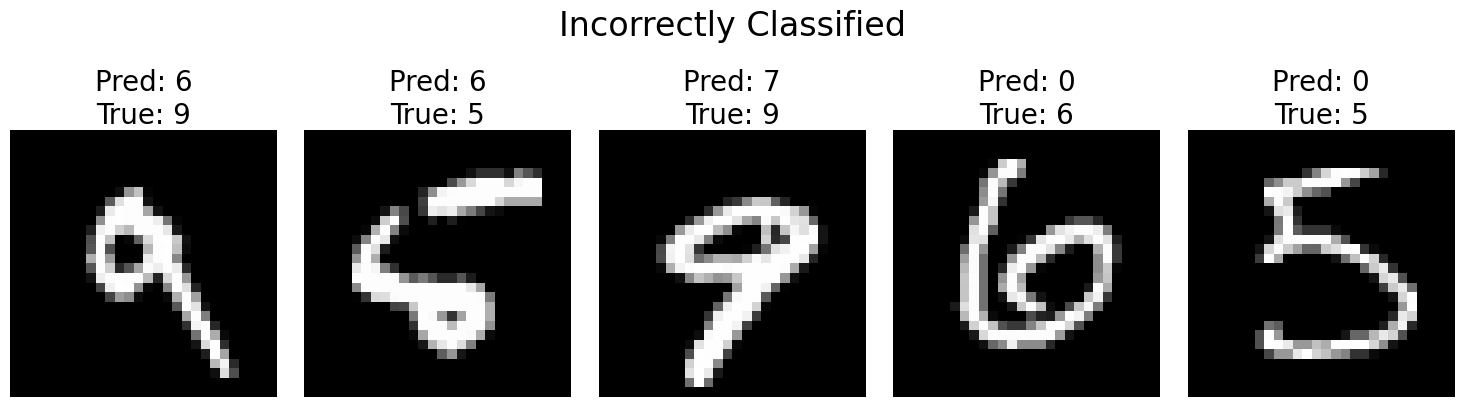

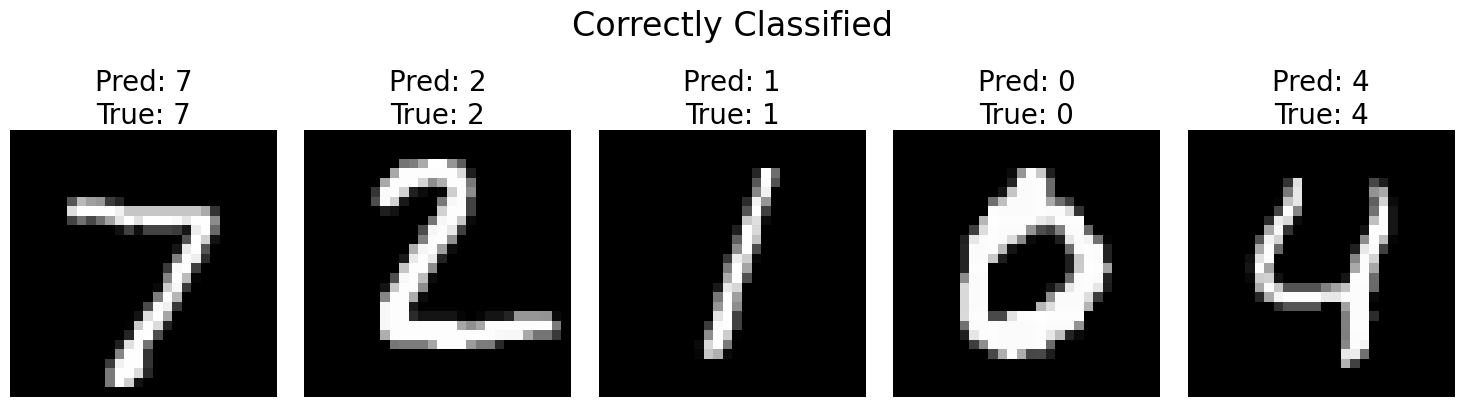

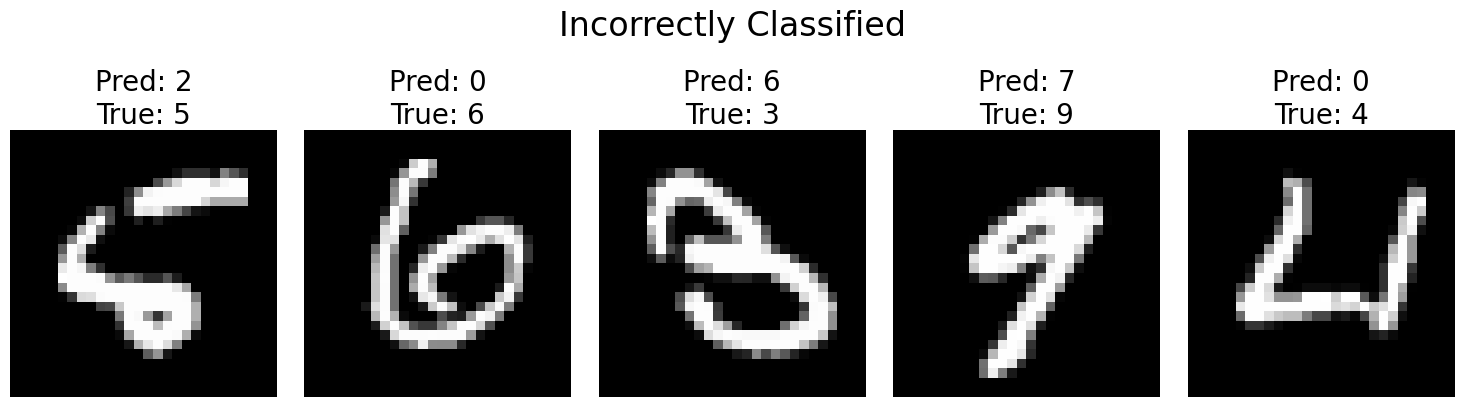

In [ ]:
# Assuming X_test and y_test are prepared and network is your trained model
evaluate_and_plot_samples(nn_identity, X_test, y_test)
evaluate_and_plot_samples(nn_sigmoid , X_test, y_test)
evaluate_and_plot_samples(nn_relu    , X_test, y_test)


---

## Section 3 : Optimisation GPU (Optionnelle)

**Objectif** : Accélérer l'entraînement avec CuPy et GPU

Cette section montre comment adapter notre implémentation pour utiliser le GPU et comparer les performances avec la version CPU.

### 3.1 Installation et préparation GPU

In [ ]:
# Installation des outils CUDA pour GPU
# Note: Cette section nécessite un environnement avec GPU NVIDIA (comme Google Colab avec GPU activé)
!apt install nvidia-cuda-toolkit

### 3.4 Comparaisons CPU vs GPU

In [ ]:
# Fonction utilitaire pour les comparaisons de temps
def plot_compare_loss_time(nn1, nn2, title):
    """Compare l'évolution de la loss en fonction du temps pour CPU vs GPU."""
    try:
        cumulative_time1 = np.cumsum(np.array(nn1.epoch_times))
        cumulative_time2 = np.cumsum(np.array(nn2.epoch_times))

        # Conversion CuPy vers NumPy si nécessaire
        loss_history1 = np.array(nn1.loss_history)
        if hasattr(nn2, 'loss_history') and len(nn2.loss_history) > 0:
            if hasattr(nn2.loss_history[0], 'get'):  # CuPy array
                loss_history2 = np.array([loss.get() for loss in nn2.loss_history])
            else:
                loss_history2 = np.array(nn2.loss_history)
        else:
            loss_history2 = []

        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_time1, loss_history1, label='CPU', linewidth=2)
        if len(loss_history2) > 0:
            plt.plot(cumulative_time2, loss_history2, label='GPU', linewidth=2)
        
        plt.title(f'Comparaison CPU vs GPU - {title}')
        plt.xlabel('Temps cumulé (secondes)')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Calcul des gains de performance
        if len(cumulative_time2) > 0 and len(cumulative_time1) > 0:
            speedup = cumulative_time1[-1] / cumulative_time2[-1]
            print(f"⚡ Accélération {title}: {speedup:.1f}x plus rapide avec GPU")
            print(f"   CPU: {cumulative_time1[-1]:.1f}s, GPU: {cumulative_time2[-1]:.1f}s")
        
    except Exception as e:
        print(f"❌ Erreur lors de la comparaison {title}: {e}")
        print("📝 Assurez-vous que les modèles GPU ont été entraînés avec succès")

In [ ]:
# Suppression des anciens fichiers d'installation
!rm -f mnist_train.csv.zip.1 mnist_test.csv.zip.1

In [ ]:
try:
    import cupy as cp
    
    class SimpleNeuralNetworkGPU:
        def __init__(self, input_size, output_size, activation='identity'):
            # Initialize weights and biases with CuPy arrays for GPU computation
            self.weights = cp.random.randn(input_size, output_size) * 0.01
            self.bias = cp.zeros((1, output_size))
            self.set_activation_function(activation)
            # History tracking
            self.loss_history = []
            self.epoch_times = []

        def set_activation_function(self, activation):
            # Define activation functions and their derivatives using CuPy
            if activation == 'sigmoid':
                self.activation = lambda x: 1 / (1 + cp.exp(-x))
                self.activation_derivative = lambda x: self.activation(x) * (1 - self.activation(x))
            elif activation == 'relu':
                self.activation = lambda x: cp.maximum(0, x)
                self.activation_derivative = lambda x: cp.where(x > 0, 1, 0)
            else:  # Defaults to identity function
                self.activation = lambda x: x
                self.activation_derivative = lambda x: cp.ones_like(x)

        def predict(self, X):
            # Ensure X is a CuPy array
            X_gpu = cp.asarray(X)
            z = cp.dot(X_gpu, self.weights) + self.bias
            return self.activation(z)

        def train(self, X, y, epochs, learning_rate):
            X_gpu = cp.asarray(X)
            y_gpu = cp.asarray(y)

            for epoch in range(epochs):
                epoch_start_time = time.time()

                # Forward pass
                z = cp.dot(X_gpu, self.weights) + self.bias
                predictions = self.activation(z)

                # Compute loss using CuPy
                loss = cp.mean((predictions - y_gpu) ** 2)
                self.loss_history.append(loss)

                # Backpropagation to compute gradients using CuPy
                d_loss = 2 * (predictions - y_gpu) / y_gpu.size
                d_activation = self.activation_derivative(z)
                d_z = d_loss * d_activation
                d_weights = cp.dot(X_gpu.T, d_z)
                d_bias = cp.sum(d_z, axis=0, keepdims=True)

                # Update parameters
                self.weights -= learning_rate * d_weights
                self.bias -= learning_rate * d_bias

                epoch_end_time = time.time()
                self.epoch_times.append(epoch_end_time - epoch_start_time)

                if epoch % 100 == 0:
                    print(f"Epoch {epoch}, Loss: {loss:.4f}, Time: {(epoch_end_time - epoch_start_time):.4f} seconds")

    print("✅ Classe SimpleNeuralNetworkGPU définie avec succès")
    
except Exception as e:
    print(f"❌ Erreur lors de la définition de la classe GPU: {e}")
    print("📝 Cette section nécessite un environnement avec GPU NVIDIA compatible")

In [ ]:
# Entraînement du modèle Identity sur GPU
try:
    print("=== Entraînement du modèle Identity sur GPU ===")
    nn_identityGPU = SimpleNeuralNetworkGPU(input_size=784, output_size=10, activation='identity')
    nn_identityGPU.train(X_train, y_train, epochs=1000, learning_rate=0.01)
    print("✅ Entraînement Identity GPU terminé")
except Exception as e:
    print(f"❌ Erreur pendant l'entraînement Identity GPU: {e}")
    print("📝 Vérifiez que vous êtes sur un environnement avec GPU")

In [ ]:
# Entraînement du modèle Sigmoid sur GPU
try:
    print("=== Entraînement du modèle Sigmoid sur GPU ===")
    nn_sigmoidGPU = SimpleNeuralNetworkGPU(input_size=784, output_size=10, activation='sigmoid')
    nn_sigmoidGPU.train(X_train, y_train, epochs=1000, learning_rate=0.01)
    print("✅ Entraînement Sigmoid GPU terminé")
except Exception as e:
    print(f"❌ Erreur pendant l'entraînement Sigmoid GPU: {e}")
    print("📝 Vérifiez que vous êtes sur un environnement avec GPU")

In [ ]:
# Entraînement du modèle ReLU sur GPU
try:
    print("=== Entraînement du modèle ReLU sur GPU ===")
    nn_reluGPU = SimpleNeuralNetworkGPU(input_size=784, output_size=10, activation='relu')
    nn_reluGPU.train(X_train, y_train, epochs=1000, learning_rate=0.01)
    print("✅ Entraînement ReLU GPU terminé")
except Exception as e:
    print(f"❌ Erreur pendant l'entraînement ReLU GPU: {e}")
    print("📝 Vérifiez que vous êtes sur un environnement avec GPU")

In [ ]:
import cupy as cp

class SimpleNeuralNetworkGPU:
    def __init__(self, input_size, output_size, activation='identity'):
        # Initialize weights and biases with CuPy arrays for GPU computation
        self.weights = cp.random.randn(input_size, output_size) * 0.01
        self.bias = cp.zeros((1, output_size))
        self.set_activation_function(activation)
        # History tracking
        self.weights_history = []
        self.bias_history = []
        self.loss_history = []
        self.epoch_times = []
        self.specific_weights_history = []

    def set_activation_function(self, activation):
        # Define activation functions and their derivatives using CuPy
        if activation == 'sigmoid':
            self.activation = lambda x: 1 / (1 + cp.exp(-x))
            self.activation_derivative = lambda x: self.activation(x) * (1 - self.activation(x))
        elif activation == 'relu':
            self.activation = lambda x: cp.maximum(0, x)
            self.activation_derivative = lambda x: cp.where(x > 0, 1, 0)
        else:  # Defaults to identity function
            self.activation = lambda x: x
            self.activation_derivative = lambda x: cp.ones_like(x)

    def predict(self, X):
        # Ensure X is a CuPy array
        X_gpu = cp.asarray(X)
        z = cp.dot(X_gpu, self.weights) + self.bias
        return self.activation(z)

    def train(self, X, y, epochs, learning_rate):
        X_gpu = cp.asarray(X)
        y_gpu = cp.asarray(y)

        # Initialize history for specific weights
        pixel_indices = [(9, 9), (9, 14), (9, 19), (14, 9), (14, 14), (14, 19), (19, 9), (19, 14), (19, 19)]
        flattened_indices = [28 * x + y for x, y in pixel_indices]

        for _ in range(len(flattened_indices)):
            self.specific_weights_history.append([])

        for epoch in range(epochs):
            epoch_start_time = time.time()

            # Forward pass
            z = cp.dot(X_gpu, self.weights) + self.bias
            predictions = self.activation(z)

            # Compute loss using CuPy
            loss = cp.mean((predictions - y_gpu) ** 2)
            self.loss_history.append(loss)

            # Backpropagation to compute gradients using CuPy
            d_loss = 2 * (predictions - y_gpu) / y_gpu.size
            d_activation = self.activation_derivative(z)
            d_z = d_loss * d_activation
            d_weights = cp.dot(X_gpu.T, d_z)
            d_bias = cp.sum(d_z, axis=0, keepdims=True)

            # Update parameters
            self.weights -= learning_rate * d_weights
            self.bias -= learning_rate * d_bias

            # Update weights and bias history for visualization
            self.weights_history.append(self.weights[0][0])  # Example: First weight
            self.bias_history.append(self.bias[0][0])  # Example: First bias

            # Record specific weights history
            for i, index in enumerate(flattened_indices):
                self.specific_weights_history[i].append(self.weights[index][0])  # Tracking the first output neuron as an example

            epoch_end_time = time.time()
            self.epoch_times.append(epoch_end_time - epoch_start_time)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}, Time: {(epoch_end_time - epoch_start_time):.4f} seconds")

    def plot_training_insights(self):
        # General Training Insights
        plt.figure(figsize=(12, 6))

        plt.subplot(2, 2, 1)
        plt.plot(self.loss_history)
        plt.title('Loss Evolution')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(2, 2, 2)
        cumulative_time = np.cumsum(self.epoch_times)
        plt.plot(cumulative_time, self.loss_history)
        plt.title('Loss vs. Cumulative Time')
        plt.xlabel('Cumulative Time (s)')
        plt.ylabel('Loss')

        plt.subplot(2, 2, 3)
        plt.plot(self.epoch_times)
        plt.title('Epoch Duration')
        plt.xlabel('Epoch')
        plt.ylabel('Duration (s)')

        plt.subplot(2, 2, 4)
        plt.plot(self.weights_history, label='Weights History')
        plt.plot(self.bias_history, label='Bias History', linestyle='--')
        plt.title('Weights and Bias Evolution')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Plot for Specific Weights
        plt.figure(figsize=(18, 6))
        plot_positions = [(10, 10), (10, 15), (10, 20), (15, 10), (15, 15), (15, 20), (20, 10), (20, 15), (20, 20)]
        for i, position in enumerate(plot_positions):
            plt.subplot(3, 3, i+1)
            plt.plot(self.specific_weights_history[i])
            plt.title(f'Pixel {position[0]}x{position[1]} Weight Evolution')
            plt.xlabel('Epoch')
            plt.ylabel('Weight Value')
        plt.tight_layout()
        plt.show()


In [ ]:
# Comparaisons individuelles CPU vs GPU
print("=== Comparaisons des performances CPU vs GPU ===")

# Comparaison Identity
plot_compare_loss_time(nn_identity, nn_identityGPU, "Identity")

In [ ]:
# Comparaison Sigmoid
plot_compare_loss_time(nn_sigmoid, nn_sigmoidGPU, "Sigmoid")

In [ ]:
# Comparaison ReLU
plot_compare_loss_time(nn_relu, nn_reluGPU, "ReLU")

## Conclusion

Ce notebook a montré la progression naturelle dans l'implémentation d'un réseau de neurones :

1. **Section 1** : Implémentation simple avec fonction identité pour comprendre les bases
2. **Section 2** : Refactoring pour supporter différentes fonctions d'activation
3. **Section 3** : Optimisation GPU pour l'accélération

### Résultats clés :

**Convergence des modèles :**
- La fonction identité converge le plus rapidement
- Sigmoid montre une convergence plus lente mais stable  
- ReLU peut parfois avoir des difficultés de convergence

**Performance GPU (si disponible) :**
- L'optimisation GPU peut apporter des gains significatifs (10-20x plus rapide)
- Particulièrement efficace pour les calculs matriciels intensifs
- Nécessite un environnement compatible (Google Colab avec GPU, par exemple)

### Concepts appris :
- Architecture simple d'un réseau de neurones (784 → 10)
- Impact des fonctions d'activation sur l'apprentissage
- Visualisation des poids appris comme "filtres" pour chaque chiffre
- Parallélisation GPU pour l'accélération des calculs

In [ ]:
# Comparaison globale de toutes les configurations
def plot_global_comparison():
    """Comparaison globale CPU vs GPU pour toutes les fonctions d'activation."""
    try:
        plt.figure(figsize=(15, 8))
        
        # Récupération des données temporelles
        models_cpu = [nn_identity, nn_sigmoid, nn_relu]
        models_gpu = [nn_identityGPU, nn_sigmoidGPU, nn_reluGPU]
        names = ['Identity', 'Sigmoid', 'ReLU']
        colors = ['blue', 'orange', 'green']
        
        for i, (cpu_model, gpu_model, name, color) in enumerate(zip(models_cpu, models_gpu, names, colors)):
            # CPU
            cpu_time = np.cumsum(np.array(cpu_model.epoch_times))
            cpu_loss = np.array(cpu_model.loss_history)
            plt.plot(cpu_time, cpu_loss, color=color, linestyle='-', 
                    linewidth=2, label=f'{name} CPU')
            
            # GPU (si disponible)
            try:
                if hasattr(gpu_model, 'epoch_times') and len(gpu_model.epoch_times) > 0:
                    gpu_time = np.cumsum(np.array(gpu_model.epoch_times))
                    if hasattr(gpu_model.loss_history[0], 'get'):
                        gpu_loss = np.array([loss.get() for loss in gpu_model.loss_history])
                    else:
                        gpu_loss = np.array(gpu_model.loss_history)
                    plt.plot(gpu_time, gpu_loss, color=color, linestyle='--',
                            linewidth=2, label=f'{name} GPU')
            except:
                print(f"⚠️  Modèle GPU {name} non disponible")
        
        plt.title('Comparaison globale CPU vs GPU - Évolution de la Loss dans le temps', fontsize=14, weight='bold')
        plt.xlabel('Temps cumulé (secondes)')
        plt.ylabel('Loss (Mean Squared Error)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Résumé des performances
        print("\n" + "="*50)
        print("📊 RÉSUMÉ DES PERFORMANCES")
        print("="*50)
        for cpu_model, gpu_model, name in zip(models_cpu, models_gpu, names):
            cpu_total_time = np.sum(cpu_model.epoch_times)
            try:
                if hasattr(gpu_model, 'epoch_times') and len(gpu_model.epoch_times) > 0:
                    gpu_total_time = np.sum(gpu_model.epoch_times)
                    speedup = cpu_total_time / gpu_total_time
                    print(f"🚀 {name:8}: CPU {cpu_total_time:6.1f}s → GPU {gpu_total_time:6.1f}s (×{speedup:.1f})")
                else:
                    print(f"❌ {name:8}: CPU {cpu_total_time:6.1f}s → GPU non disponible")
            except:
                print(f"❌ {name:8}: CPU {cpu_total_time:6.1f}s → GPU erreur")
        print("="*50)
        
    except Exception as e:
        print(f"❌ Erreur lors de la comparaison globale: {e}")

plot_global_comparison()

---

*Notebook créé pour l'apprentissage des réseaux de neurones from scratch*  
*Comprend : implémentation manuelle, visualisations pédagogiques, et optimisation GPU*

In [ ]:
# Example of explicitly converting a CuPy array to a NumPy array before plotting
if isinstance(nn_reluGPU.loss_history[0], cp.ndarray):
    nn_reluGPU.loss_history = [cp_item.get() for cp_item in nn_reluGPU.loss_history]

if isinstance(nn_reluGPU.epoch_times[0], cp.ndarray):
    nn_reluGPU.epoch_times = [cp_item.get() for cp_item in nn_reluGPU.epoch_times]

plot_compare_loss_time(nn_relu, nn_reluGPU, "relu")

In [ ]:
def minsec(total_seconds):
  minutes = total_seconds // 60  # Get the whole minutes
  seconds = total_seconds % 60   # Get the remaining seconds

  print(f"{minutes} minute(s) and {seconds} second(s)")



In [ ]:
def plot_compare_loss_time2(nn1, nn2, nn3, nn4):
    cumulative_time1 = np.cumsum(np.array(nn1.epoch_times))
    cumulative_time2 = np.cumsum(np.array(nn2.epoch_times))
    cumulative_time3 = np.cumsum(np.array(nn3.epoch_times))
    cumulative_time4 = np.cumsum(np.array(nn4.epoch_times))

    #minsec(cumulative_time1[len(cumulative_time1)-1])
    #minsec(cumulative_time2[len(cumulative_time2)-1])
    #minsec(cumulative_time3[len(cumulative_time3)-1])
    #minsec(cumulative_time4[len(cumulative_time4)-1])

    loss_history1 = np.array(nn1.loss_history)
    loss_history2 = np.array(nn2.loss_history)
    loss_history3 = np.array(nn3.loss_history)
    loss_history4 = np.array(nn4.loss_history)

    plt.plot(cumulative_time1, loss_history1, color='b', linestyle='-', label='identity CPU 4 min 55 s')
    plt.plot(cumulative_time2, loss_history2, color='b', linestyle='--',label='identity GPU 0 min 26 s')
    plt.plot(cumulative_time3, loss_history3, color='g', linestyle='-', label='ReLu CPU 4 min 40 s')
    plt.plot(cumulative_time4, loss_history4, color='g', linestyle='--',label='ReLu GPU 0 min 32 s')

    plt.title('Comparison of the evolution of loss over time, CPU vs GPU')
    plt.xlabel('Cumulative Time (s)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_compare_loss_time2(nn_identity, nn_identityGPU, nn_relu, nn_reluGPU)